In [1]:
from dypac.masker import LabelsMasker, MapsMasker
from nilearn.plotting import plot_roi, plot_stat_map
from nilearn import datasets

Fetch a preprocessed dataset

In [2]:
from nilearn import datasets
n_subjects = 1
dev_dataset = datasets.fetch_adhd(n_subjects=n_subjects)
epi_filename = dev_dataset.func[0]

/home/pbellec/env/dypac/lib/python3.8/site-packages/nilearn/datasets/func.py:250: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  phenotypic = np.genfromtxt(phenotypic, names=True, delimiter=',',


# "hard parcels": the Schaefer atlas

In [ ]:
atlas = datasets.fetch_atlas_schaefer_2018()

In [ ]:
from nilearn.maskers import NiftiMasker
masker = NiftiMasker(standardize=True, detrend=True)
masker.fit(epi_filename)

In [ ]:
labels_masker = LabelsMasker(masker=masker, labels_img=atlas.maps)

In [ ]:
masker.mask_img_

In [ ]:
labels_masker.masker_.mask_img_

In [ ]:
plot_roi(labels_masker.masker_.inverse_transform(labels_masker.components_[:,2].todense().transpose()), resampling_interpolation='nearest')

In [ ]:
r2_map = labels_masker.score(img=[epi_filename])

In [ ]:
import numpy as np
plot_stat_map(r2_map, vmax=1)
r2_val = NiftiMasker(standardize=False, mask_img=masker.mask_img).fit_transform(r2_map)
print(f'Average R2: {np.mean(r2_val)}')

# "soft" parcels: the ICA atlas from Smith et al. (2009)

In [3]:
ica_maps = datasets.fetch_atlas_smith_2009()

In [4]:
from nilearn.maskers import NiftiMasker
masker = NiftiMasker(standardize=True, detrend=True)
masker.fit(epi_filename)

NiftiMasker(detrend=True, standardize=True)

In [5]:
maps_masker = MapsMasker(masker=masker, maps_img=ica_maps.rsn70)

/home/pbellec/env/dypac/lib/python3.8/site-packages/nilearn/plotting/img_plotting.py:348: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


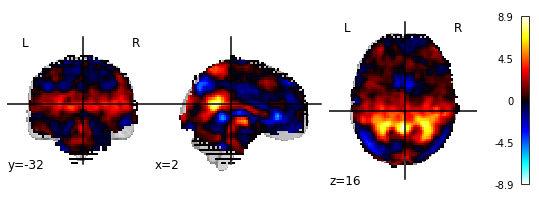

In [7]:
plot_stat_map(maps_masker.masker_.inverse_transform(maps_masker.components_[:, 5].transpose()))

In [8]:
r2_map = maps_masker.score(img=epi_filename)

Average R2: 0.06549398006910229


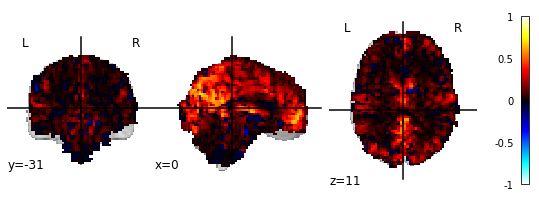

In [10]:
import numpy as np
plot_stat_map(r2_map, vmax=1)
r2_val = NiftiMasker(standardize=False, mask_img=masker.mask_img).fit_transform(r2_map)
print(f'Average R2: {np.mean(r2_val)}')

# Difumo

In [17]:
difumo_maps = datasets.fetch_atlas_difumo(dimension=1024)

Downloaded 9764864 of 13322151 bytes (73.3%,    0.4s remaining) ...done. (2 seconds, 0 min)
Extracting data from /home/pbellec/nilearn_data/difumo_atlases/c8976fee9fff3ddf39f27fef23a00765/download..... done.
/home/pbellec/env/dypac/lib/python3.8/site-packages/nilearn/datasets/atlas.py:129: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)


In [19]:
from nilearn.maskers import NiftiMasker
masker = NiftiMasker(standardize=True, detrend=True)
masker.fit(epi_filename)

NiftiMasker(detrend=True, standardize=True)

In [20]:
maps_masker = MapsMasker(masker=masker, maps_img=difumo_maps.maps)

/home/pbellec/env/dypac/lib/python3.8/site-packages/nilearn/maskers/nifti_masker.py:475: UserWarning: Persisting input arguments took 2.53s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  data = self._cache(_filter_and_mask,


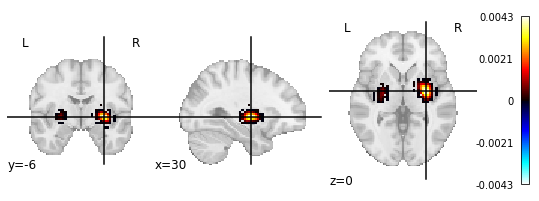

In [21]:
plot_stat_map(maps_masker.masker_.inverse_transform(maps_masker.components_[:, 5].transpose()))

In [22]:
r2_map = maps_masker.score(img=epi_filename)

Average R2: 0.16092547722834316


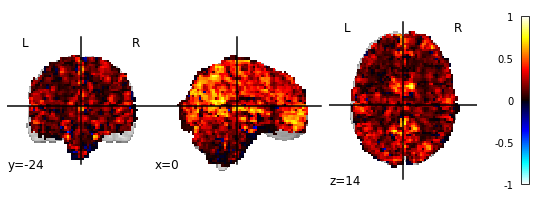

In [23]:
import numpy as np
plot_stat_map(r2_map, vmax=1)
r2_val = NiftiMasker(standardize=False, mask_img=masker.mask_img).fit_transform(r2_map)
print(f'Average R2: {np.mean(r2_val)}')